In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from itertools import cycle, islice
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

%matplotlib inline

In [2]:
data = pd.read_csv('minute_weather.csv')

In [3]:
data.shape

(1587257, 13)

In [4]:
data.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


In [5]:
sampled_df = data[(data['rowID'] % 10) == 0]
sampled_df.shape

(158726, 13)

In [6]:
# Statistics
sampled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,158726.0,793625.000000,458203.937509,0.00,396812.5,793625.00,1190437.50,1587250.00
air_pressure,158726.0,916.830161,3.051717,905.00,914.8,916.70,918.70,929.50
air_temp,158726.0,61.851589,11.833569,31.64,52.7,62.24,70.88,99.50
avg_wind_direction,158680.0,162.156100,95.278201,0.00,62.0,182.00,217.00,359.00
avg_wind_speed,158680.0,2.775215,2.057624,0.00,1.3,2.20,3.80,31.90
max_wind_direction,158680.0,163.462144,92.452139,0.00,68.0,187.00,223.00,359.00
max_wind_speed,158680.0,3.400558,2.418802,0.10,1.6,2.70,4.60,36.00
min_wind_direction,158680.0,166.774017,97.441109,0.00,76.0,180.00,212.00,359.00
min_wind_speed,158680.0,2.134664,1.742113,0.00,0.8,1.60,3.00,31.60
rain_accumulation,158725.0,0.000318,0.011236,0.00,0.0,0.00,0.00,3.12


In [7]:
sampled_df[sampled_df['rain_accumulation'] == 0].shape

(157812, 13)

In [8]:
sampled_df[sampled_df['rain_duration'] == 0].shape

(157237, 13)

In [9]:
#Drop all the Rows with Empty rain_duration and rain_accumulation
del sampled_df['rain_accumulation']
del sampled_df['rain_duration']

In [10]:
rows_before = sampled_df.shape[0]
sampled_df = sampled_df.dropna()
rows_after = sampled_df.shape[0]

In [11]:
#How many rows did we drop ?
rows_before - rows_after

46

In [12]:
sampled_df.columns

Index(['rowID', 'hpwren_timestamp', 'air_pressure', 'air_temp',
       'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction',
       'max_wind_speed', 'min_wind_direction', 'min_wind_speed',
       'relative_humidity'],
      dtype='object')

In [13]:
#Select Features of Interest for Clustering
features = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']

In [14]:
select_df = sampled_df[features]

In [15]:
select_df.columns

Index(['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed',
       'max_wind_direction', 'max_wind_speed', 'relative_humidity'],
      dtype='object')

In [16]:
select_df

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,912.3,64.76,97.0,1.2,106.0,1.6,60.5
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5
20,912.2,63.32,100.0,2.0,122.0,2.5,58.3
30,912.2,62.60,91.0,2.0,103.0,2.4,57.9
40,912.2,64.04,81.0,2.6,88.0,2.9,57.4
50,912.1,63.68,102.0,1.2,119.0,1.5,51.4
60,912.0,64.04,83.0,0.7,101.0,0.9,51.4
70,911.9,64.22,82.0,2.0,97.0,2.4,62.2
80,911.9,61.70,67.0,3.3,70.0,3.5,71.5
90,911.9,61.34,67.0,3.6,75.0,4.2,72.5


In [17]:
#Scale the Features using StandardScaler
X = StandardScaler().fit_transform(select_df)
X

array([[-1.48456281,  0.24544455, -0.68385323, ..., -0.62153592,
        -0.74440309,  0.49233835],
       [-1.48456281,  0.03247142, -0.19055941, ...,  0.03826701,
        -0.66171726, -0.34710804],
       [-1.51733167,  0.12374562, -0.65236639, ..., -0.44847286,
        -0.37231683,  0.40839371],
       ...,
       [-0.30488381,  1.15818654,  1.90856325, ...,  2.0393087 ,
        -0.70306017,  0.01538018],
       [-0.30488381,  1.12776181,  2.06599745, ..., -1.67073075,
        -0.74440309, -0.04948614],
       [-0.30488381,  1.09733708, -1.63895404, ..., -1.55174989,
        -0.62037434, -0.05711747]])

In [18]:
#Use k-Means Clustering
kmeans = KMeans(n_clusters=12)
model = kmeans.fit(X)
print("model\n", model)

model
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [19]:
#What are the centers of 12 clusters we formed ?
centers = model.cluster_centers_
centers

array([[ 0.05753244, -0.78541804, -1.19607119, -0.571059  , -1.04216244,
        -0.58563667,  0.87647012],
       [ 0.75521322,  0.40270227,  0.29147506, -0.52686572,  0.47866316,
        -0.53280258, -0.76853799],
       [ 1.36832762, -0.08165327, -1.20734305, -0.04664869, -1.0763219 ,
        -0.02618826, -0.97767464],
       [-1.18244149, -0.87054903,  0.44687552,  1.98374387,  0.53834646,
         1.9447643 ,  0.90874814],
       [ 0.23221177, -0.99650437,  0.65657534, -0.54856334,  0.84614102,
        -0.53134792,  1.16721642],
       [-0.83884624, -1.1983058 ,  0.37498443,  0.37207757,  0.47358518,
         0.35989599,  1.35905068],
       [-0.2142379 ,  0.63301205,  0.40822425,  0.73472931,  0.51631194,
         0.67261169, -0.14963187],
       [ 0.23380635,  0.32025785,  1.88785757, -0.65187638, -1.55176624,
        -0.57675056, -0.28388426],
       [-0.16174738,  0.86295055, -1.31022259, -0.59013117, -1.16578643,
        -0.6054219 , -0.64284401],
       [ 1.1901647 , -0.2553

In [20]:
#Let us first create some utility functions which will help us in plotting graphs:
# Function that creates a DataFrame with a column for Cluster Number

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas data frame for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

In [21]:
# Function that creates Parallel Plots

def parallel_plot(data):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [22]:
P = pd_centers(features, centers)
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,0.057532,-0.785418,-1.196071,-0.571059,-1.042162,-0.585637,0.876470,0
1,0.755213,0.402702,0.291475,-0.526866,0.478663,-0.532803,-0.768538,1
2,1.368328,-0.081653,-1.207343,-0.046649,-1.076322,-0.026188,-0.977675,2
3,-1.182441,-0.870549,0.446876,1.983744,0.538346,1.944764,0.908748,3
4,0.232212,-0.996504,0.656575,-0.548563,0.846141,-0.531348,1.167216,4
5,-0.838846,-1.198306,0.374984,0.372078,0.473585,0.359896,1.359051,5
6,-0.214238,0.633012,0.408224,0.734729,0.516312,0.672612,-0.149632,6
7,0.233806,0.320258,1.887858,-0.651876,-1.551766,-0.576751,-0.283884,7
8,-0.161747,0.862951,-1.310223,-0.590131,-1.165786,-0.605422,-0.642844,8
9,1.190165,-0.255315,-1.154965,2.125398,-1.053476,2.242288,-1.134561,9


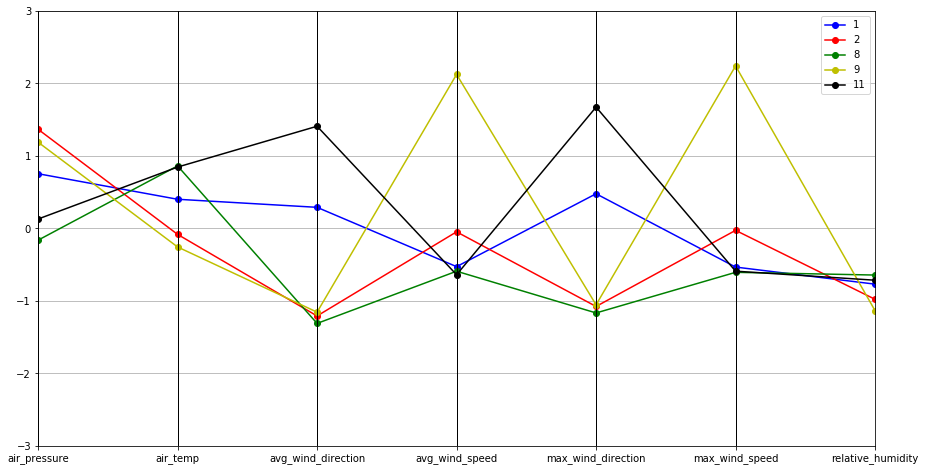

In [23]:
# Dry Days
parallel_plot(P[P['relative_humidity'] < -0.5])

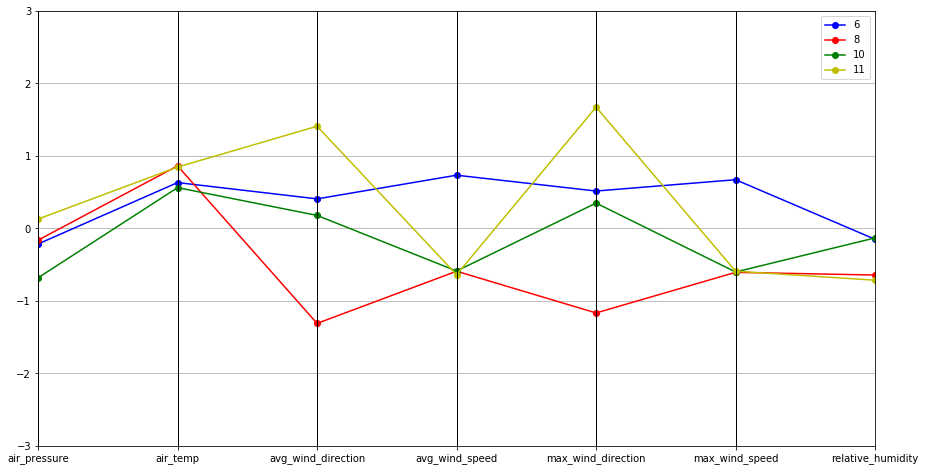

In [24]:
# Warm Days
parallel_plot(P[P['air_temp'] > 0.5])

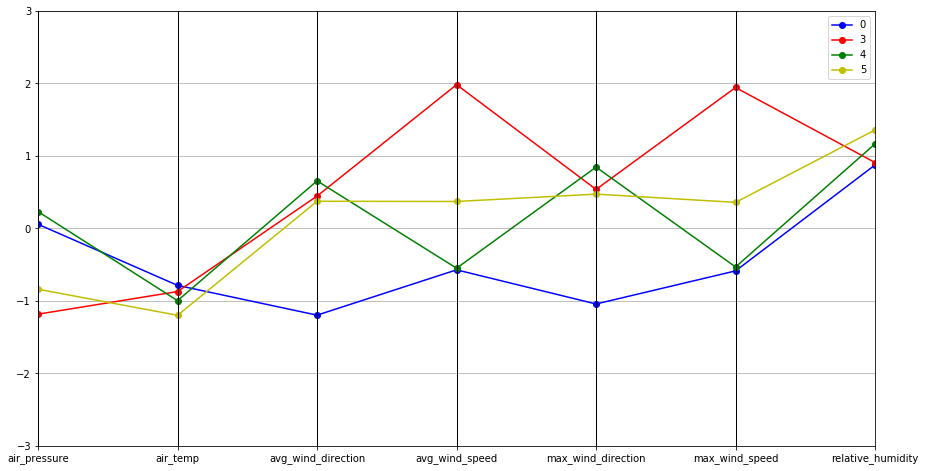

In [25]:
#Cool Days
parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)])